In [1]:
# IMPORTS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import joblib
from joblib import dump, load
import pickle
from scipy.stats import randint
from imblearn.over_sampling import RandomOverSampler
import os
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
from sklearn.exceptions import NotFittedError
from imblearn.pipeline import make_pipeline


In [2]:
#df without others gens

df = pd.read_csv(r'C:\Users\teka_\DATA SCIENCE\Concordia-Bootcamps\FINAL PROJECT\Final\df_wo_othersGens.csv')
df

,snpID,class,chromosome,position,most_severe_consequence,GeneID,sourceId,protein_class_name,protein_class,Disease Class,Category,Gene/Protein Symbol
0,rs1000256867,snv,17,7673550,missense variant,7157,VEP,Transcription factor,DTO_05007542,cervical intraepithelial neoplasia; papillomav...,cancer,TP53
1,rs1000256867,snv,17,7673550,missense variant,7157,VEP,Transcription factor,DTO_05007542,"carcinoma, squamous cell; esophageal neoplasms...",cancer,TP53
2,rs1000256867,snv,17,7673550,missense variant,7157,VEP,Transcription factor,DTO_05007542,duodenal ulcer; helicobacter infections; stoma...,cancer,TP53
3,rs1000256867,snv,17,7673550,missense variant,7157,VEP,Transcription factor,DTO_05007542,oral lichen planus,infection,TP53
4,rs1000256867,snv,17,7673550,missense variant,7157,VEP,Transcription factor,DTO_05007542,kaposi's sarcoma,cancer,TP53
...,...,...,...,...,...,...,...,...,...,...,...,...
535090,rs967624732,snv,17,43097269,missense variant,672,VEP,Enzyme,DTO_05007624,"breast neoplasms; cell transformation, neoplas...",cancer,BRCA1
535091,rs967624732,snv,17,43097269,missense variant,672,VEP,Enzyme,DTO_05007624,"breast cancer, male",cancer,BRCA1
535092,rs967624732,snv,17,43097269,missense variant,672,VEP,Enzyme,DTO_05007624,breast neoplasms; mammary neoplasms; neoplasms...,cancer,BRCA1
535093,rs967624732,snv,17,43097269,missense variant,672,VEP,Enzyme,DTO_05007624,ovarian diseases,reproduction,BRCA1


In [3]:
# Colunas a serem removidas
columns_to_drop = ['snpID', 'GeneID', 'sourceId', 'protein_class_name', 'protein_class', 'Disease Class']

# Removendo as colunas
df = df.drop(columns=columns_to_drop)
df

,class,chromosome,position,most_severe_consequence,Category,Gene/Protein Symbol
0,snv,17,7673550,missense variant,cancer,TP53
1,snv,17,7673550,missense variant,cancer,TP53
2,snv,17,7673550,missense variant,cancer,TP53
3,snv,17,7673550,missense variant,infection,TP53
4,snv,17,7673550,missense variant,cancer,TP53
...,...,...,...,...,...,...
535090,snv,17,43097269,missense variant,cancer,BRCA1
535091,snv,17,43097269,missense variant,cancer,BRCA1
535092,snv,17,43097269,missense variant,cancer,BRCA1
535093,snv,17,43097269,missense variant,reproduction,BRCA1


# RANDOM FOREST

Features: Class, Chromosome, Position, Most Serious Consequence, Category

In [4]:
# Stratified sampling function
def stratified_sample(df, frac):
    return df.groupby('Gene/Protein Symbol', group_keys=False).apply(lambda x: x.sample(frac=frac))

# Preprocessing function
def preprocess_data(df, frac=1):
    # Stratified sampling
    df_sampled = stratified_sample(df, frac)

    # Identifying categorical and numerical columns
    categorical_features = ['class', 'most_severe_consequence', 'Category']
    numerical_features = ['chromosome', 'position']

    # Defining the preprocessor using OneHotEncoder
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', numerical_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features)
        ]
    )

    # Complete pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

    # Applying the pipeline
    X = pipeline.fit_transform(df_sampled)
    
    # Encoding the target (LabelEncoder)
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(df_sampled['Gene/Protein Symbol'])

    # Saving the LabelEncoder and the preprocessor
    joblib.dump(label_encoder, 'label_encoder.joblib')
    joblib.dump(preprocessor, 'preprocessor.joblib')
    
    with open('label_encoder.pkl', 'wb') as le_file:
        pickle.dump(label_encoder, le_file)
    with open('preprocessor.pkl', 'wb') as p_file:
        pickle.dump(preprocessor, p_file)

    # Mapping classes
    label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))
    for original, encoded in label_mapping.items():
        print(f"Class {original}: {encoded}")

    return X, y, label_encoder, preprocessor


### BASIC

Class ATM: 0
Class BRCA1: 1
Class BRCA2: 2
Class CHEK2: 3
Class PIK3CA: 4
Class PTEN: 5
Class TP53: 6
Accuracy of Random Forest classifier on test set: 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7590
           1       1.00      1.00      1.00     84240
           2       1.00      1.00      1.00     12877
           3       1.00      1.00      1.00       940
           4       1.00      1.00      1.00       647
           5       1.00      1.00      1.00      1152
           6       1.00      1.00      1.00     53083

    accuracy                           1.00    160529
   macro avg       1.00      1.00      1.00    160529
weighted avg       1.00      1.00      1.00    160529



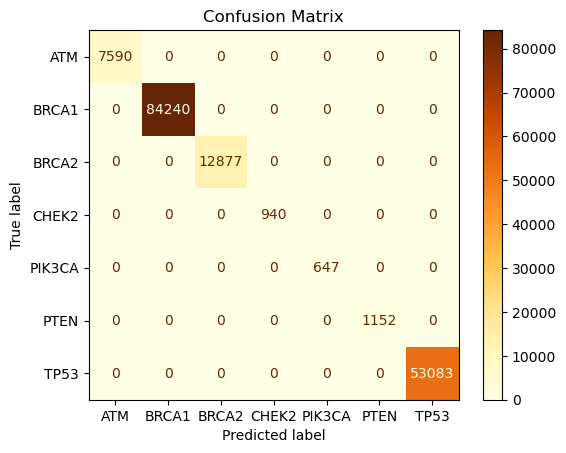

In [5]:
# Calling the preprocessing function
X, y, label_encoder, preprocessor = preprocess_data(df)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalizing the numerical data
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[:, :2])  # The first 2 columns are numerical
X_test_num_scaled = scaler.transform(X_test[:, :2])

# Saving the scaler with joblib and pickle
dump(scaler, 'scaler_basic.joblib')

with open('scaler_basic.pkl', 'wb') as le_file:
    pickle.dump(scaler, le_file)

# Recombining the scaled numerical columns with the categorical columns
numerical_features = ['chromosome', 'position']
X_train_final = pd.DataFrame(X_train_num_scaled, columns=numerical_features, index=range(len(X_train)))
X_test_final = pd.DataFrame(X_test_num_scaled, columns=numerical_features, index=range(len(X_test)))
cat_features_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(['class', 'most_severe_consequence', 'Category'])
X_train_final = pd.concat([X_train_final, pd.DataFrame(X_train[:, 2:], columns=cat_features_encoded, index=range(len(X_train)))], axis=1)
X_test_final = pd.concat([X_test_final, pd.DataFrame(X_test[:, 2:], columns=cat_features_encoded, index=range(len(X_test)))], axis=1)

# Converting column names to strings
X_train_final.columns = X_train_final.columns.astype(str)
X_test_final.columns = X_test_final.columns.astype(str)

# Building and training the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_final, y_train)

# Saving the trained model with joblib and pickle
dump(model, 'model_randomforest_basic.joblib')

model_randomforest_basic = 'model_randomforest_basic.pkl'
with open(model_randomforest_basic, 'wb') as file:
    pickle.dump(model, file)

# Making predictions and evaluations
predictions = model.predict(X_test_final)

# Generating and displaying the classification report
print("Accuracy of Random Forest classifier on test set: {:.2f}".format(model.score(X_test_final, y_test)))
print(classification_report(y_test, predictions))

# Generating and displaying the confusion matrix
cm = confusion_matrix(y_test, predictions)

# Visualizing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.YlOrBr)
plt.title("Confusion Matrix")
plt.show()


GridSerach

In [6]:
# #1
# def stratified_sample(df, frac):
#     # Group by the 'Gene/Protein Symbol' column and apply sampling within each group
#     df_sample = df.groupby('Gene/Protein Symbol', group_keys=False).apply(lambda x: x.sample(frac=frac))
#     return df_sample



# df_sampled = stratified_sample(df, frac=0.2) 

In [7]:
# # Dropping 'Gene/Protein Symbol' column from df_sampled
# X = df_sampled.drop(columns=['Gene/Protein Symbol'])
# y = df_sampled['Gene/Protein Symbol']

# # Selecting only the specified categorical and numerical columns
# categorical_columns = ['class', 'most_severe_consequence', 'Category']
# numerical_columns = ['chromosome', 'position']

# # Encoding categorical columns
# encoder = OneHotEncoder(sparse_output=False, drop='first')
# encoded_categorical_data = encoder.fit_transform(X[categorical_columns])

# # Creating a new DataFrame with the encoded columns
# encoded_categorical_df = pd.DataFrame(encoded_categorical_data, columns=encoder.get_feature_names_out(categorical_columns))

# # Concatenating numerical and encoded data
# X_encoded = pd.concat([X[numerical_columns].reset_index(drop=True), encoded_categorical_df], axis=1)

# # Resetting indices to align X_encoded and y
# X_encoded.reset_index(drop=True, inplace=True)
# y.reset_index(drop=True, inplace=True)

# #Filtering the data to select only the 'XXXX' class
# X_class_0 = X_encoded[y == 'PIK3CA']
# y_class_0 = y[y == 'PIK3CA']

# # Selecting 20% of 'XXXX' class data for testing
# X_train_class_0, X_test_class_0, y_train_class_0, y_test_class_0 = train_test_split(X_class_0, y_class_0, test_size=0.2, random_state=42)

# # Defining the hyperparameter search space
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [4, 8, 12],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }

# # Creating a Random Forest classifier
# rfc = RandomForestClassifier(random_state=42)

# # Creating a GridSearchCV object
# grid_search = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, scoring='accuracy')

# # Fitting the grid search to the data
# grid_search.fit(X_train_class_0, y_train_class_0)

# # Obtaining the best model and parameters
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_

# # Making predictions using the best model
# predictions = best_model.predict(X_test_class_0)

# # Evaluating the accuracy of the model on the test set
# accuracy = accuracy_score(y_test_class_0, predictions)
# print(f"Accuracy with best hyperparameters: {accuracy:.4f}")

# # Printing the best hyperparameters
# print("Best Hyperparameters:")
# for param_name, param_value in best_params.items():
#     print(f"\t{param_name}: {param_value}")

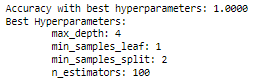

### class_weight=balanced

Class ATM: 0
Class BRCA1: 1
Class BRCA2: 2
Class CHEK2: 3
Class PIK3CA: 4
Class PTEN: 5
Class TP53: 6
Accuracy of Random Forest classifier on test set: 0.95
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      7590
           1       1.00      0.91      0.95     84240
           2       0.98      0.95      0.96     12877
           3       0.65      1.00      0.79       940
           4       1.00      1.00      1.00       647
           5       1.00      1.00      1.00      1152
           6       0.87      1.00      0.93     53083

    accuracy                           0.95    160529
   macro avg       0.93      0.97      0.94    160529
weighted avg       0.95      0.95      0.95    160529



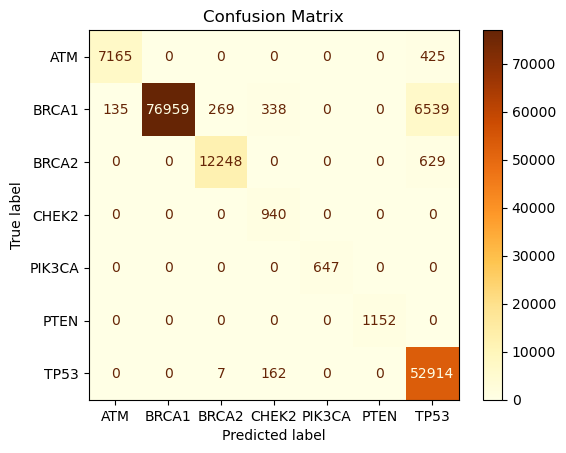

In [8]:
# Calling the preprocessing function
X, y, label_encoder, preprocessor = preprocess_data(df)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Normalizing the numerical data
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[:, :2])  # The first 2 columns are numerical
X_test_num_scaled = scaler.transform(X_test[:, :2])

# Saving the scaler with joblib and pickle
dump(scaler, 'scaler_randomforest_class_weight_balanced.joblib')

with open('scaler_randomforest_class_weight_balanced.pkl', 'wb') as le_file:
    pickle.dump(scaler, le_file)

# Recombining the scaled numerical columns with the categorical columns
numerical_features = ['chromosome', 'position']
X_train_final = pd.DataFrame(X_train_num_scaled, columns=numerical_features)
X_test_final = pd.DataFrame(X_test_num_scaled, columns=numerical_features)
cat_features_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(['class', 'most_severe_consequence', 'Category'])
X_train_final = pd.concat([X_train_final, pd.DataFrame(X_train[:, 2:], columns=cat_features_encoded)], axis=1)
X_test_final = pd.concat([X_test_final, pd.DataFrame(X_test[:, 2:], columns=cat_features_encoded)], axis=1)

# Building and training the model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    min_samples_split=2, 
    min_samples_leaf=1,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train_final, y_train)

# Saving the trained model with joblib and pickle
dump(rf_model, 'model_randomforest_class_weight_balanced.joblib')

model_randomforest_class_weight_balanced = 'model_randomforest_class_weight_balanced.pkl'
with open(model_randomforest_class_weight_balanced, 'wb') as file:
    pickle.dump(rf_model, file)

# Making predictions and evaluations
rf_predictions = rf_model.predict(X_test_final)

# Generating and displaying the classification report
print("Accuracy of Random Forest classifier on test set: {:.2f}".format(rf_model.score(X_test_final, y_test)))
print(classification_report(y_test, rf_predictions))

# Generating and displaying the confusion matrix
cm = confusion_matrix(y_test, rf_predictions)

# Visualizing the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap=plt.cm.YlOrBr)
plt.title("Confusion Matrix")
plt.show()


### Upsampling 7x with RandomOverSampler + class_weight=balanced

Class ATM: 0
Class BRCA1: 1
Class BRCA2: 2
Class CHEK2: 3
Class PIK3CA: 4
Class PTEN: 5
Class TP53: 6
Accuracy of Random Forest classifier on test set: 0.95
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      7590
           1       1.00      0.91      0.96     84241
           2       1.00      0.95      0.97     12877
           3       0.91      1.00      0.95      6577
           4       0.96      1.00      0.98       647
           5       1.00      1.00      1.00      1152
           6       0.88      1.00      0.93     53083

    accuracy                           0.95    166167
   macro avg       0.96      0.97      0.96    166167
weighted avg       0.95      0.95      0.95    166167



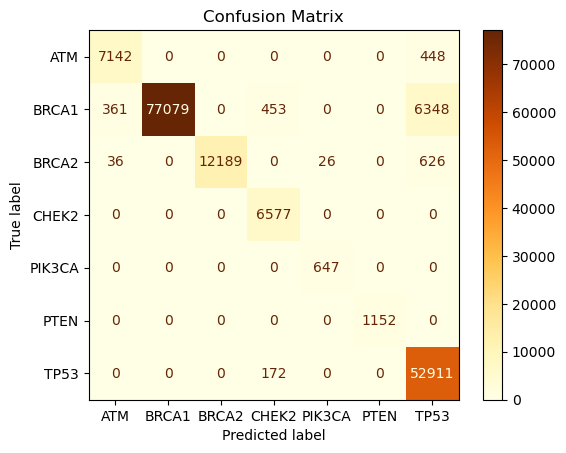

In [9]:
# Applying the preprocess_data function
X, y, label_encoder, preprocessor = preprocess_data(df)

# Applying the RandomOverSampler to balance class 3
ros = RandomOverSampler(sampling_strategy={3: y[y == 3].shape[0] * 7}, random_state=42)
X_res, y_res = ros.fit_resample(X, y)

# Splitting the balanced data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42, stratify=y_res)

# Normalizing the numerical data
scaler = StandardScaler()
X_train_num_scaled = scaler.fit_transform(X_train[:, :2])  # The first two columns are numerical
X_test_num_scaled = scaler.transform(X_test[:, :2])

# Saving the scaler with joblib and pickle
joblib.dump(scaler, 'scaler_randomforest_upsampling_class_weight_balanced.joblib')
with open('scaler_randomforest_upsampling_class_weight_balanced.pkl', 'wb') as le_file:
    pickle.dump(scaler, le_file)

# Creating DataFrames of the scaled data
numerical_features = ['chromosome', 'position']
X_train_scaled_df = pd.DataFrame(X_train_num_scaled, columns=numerical_features, index=range(X_train_num_scaled.shape[0]))
X_test_scaled_df = pd.DataFrame(X_test_num_scaled, columns=numerical_features, index=range(X_test_num_scaled.shape[0]))

# Identifying categorical columns
cat_features_encoded = preprocessor.named_transformers_['cat'].get_feature_names_out(['class', 'most_severe_consequence', 'Category'])

# Recombining the scaled numerical columns with the categorical columns
X_train_final = pd.concat([X_train_scaled_df, pd.DataFrame(X_train[:, 2:], columns=cat_features_encoded, index=range(X_train.shape[0]))], axis=1)
X_test_final = pd.concat([X_test_scaled_df, pd.DataFrame(X_test[:, 2:], columns=cat_features_encoded, index=range(X_test.shape[0]))], axis=1)

# Building and training the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=4,
    min_samples_split=2, 
    min_samples_leaf=1,
    random_state=42,
    class_weight="balanced"
)
rf_model.fit(X_train_final, y_train)

# Saving the trained model with joblib and pickle
joblib.dump(rf_model, 'model_randomforest_upsampling_class_weight_balanced.joblib')

model_randomforest_upsampling_class_weight_balanced = 'model_randomforest_upsampling_class_weight_balanced.pkl'
with open('model_randomforest_upsampling_class_weight_balanced.pkl', 'wb') as file:
    pickle.dump(rf_model, file)

# Making predictions and evaluations
rf_predictions = rf_model.predict(X_test_final)

# Generating and displaying the classification report
print("Accuracy of Random Forest classifier on test set: {:.2f}".format(rf_model.score(X_test_final, y_test)))
print(classification_report(y_test, rf_predictions))

# Generating and displaying the confusion matrix
rf_cm = confusion_matrix(y_test, rf_predictions)

# Visualizing the confusion matrix with labels
rf_disp = ConfusionMatrixDisplay(confusion_matrix=rf_cm, display_labels=label_encoder.classes_)
rf_disp.plot(cmap=plt.cm.YlOrBr)
plt.title("Confusion Matrix")
plt.show()


## Prediction

In [10]:
def predict_cancer():
    # Loading the model, scaler, and label encoder
    model = load('model_randomforest_upsampling_class_weight_balanced.joblib')
    scaler = load('scaler_randomforest_upsampling_class_weight_balanced.joblib')
    label_encoder = load('label_encoder.joblib')
    
    # #Requesting user input
    print("Please enter the values for the features:")
    user_input = {
        'class': input("class: "),
        'chromosome': input("chromosome: "),
        'position': input("position: "),
        'most_severe_consequence': input("most_severe_consequence: "),
        'Category': input("Category: ")
    }
    
    # Converting user input into a DataFrame
    input_df = pd.DataFrame([user_input])

    # Aplicando One-Hot Encoding
    input_df_encoded = pd.get_dummies(input_df, columns=['class', 'most_severe_consequence', 'Category'], drop_first=True)
    
    # Garantindo que todas as características de treinamento estejam presentes
    missing_cols = set(X_train.columns) - set(input_df_encoded.columns)
    for col in missing_cols:
        input_df_encoded[col] = 0
    input_df_encoded = input_df_encoded.reindex(columns=X_train.columns, fill_value=0)
    
    # Scaling numerical features
    input_df_encoded[numerical_features] = scaler.transform(input_df_encoded[numerical_features])
    
    # Making predictions
    prediction = model.predict(input_df_encoded)
    predicted_class = label_encoder.inverse_transform(prediction)
    
    # Getting the probabilities of the prediction
    probabilities = model.predict_proba(input_df_encoded)
    predicted_class_probability = np.max(probabilities)
    predicted_class_label = prediction[0]
    
    #print(f"The predicted Gene/Protein Symbol is: {predicted_class[0]}")
    print(f"The predicted Gene/Protein Symbol is {predicted_class[0]} with {predicted_class_probability * 100:.2f}% confidence.")



## Visualization

##### Importance of features after OHE

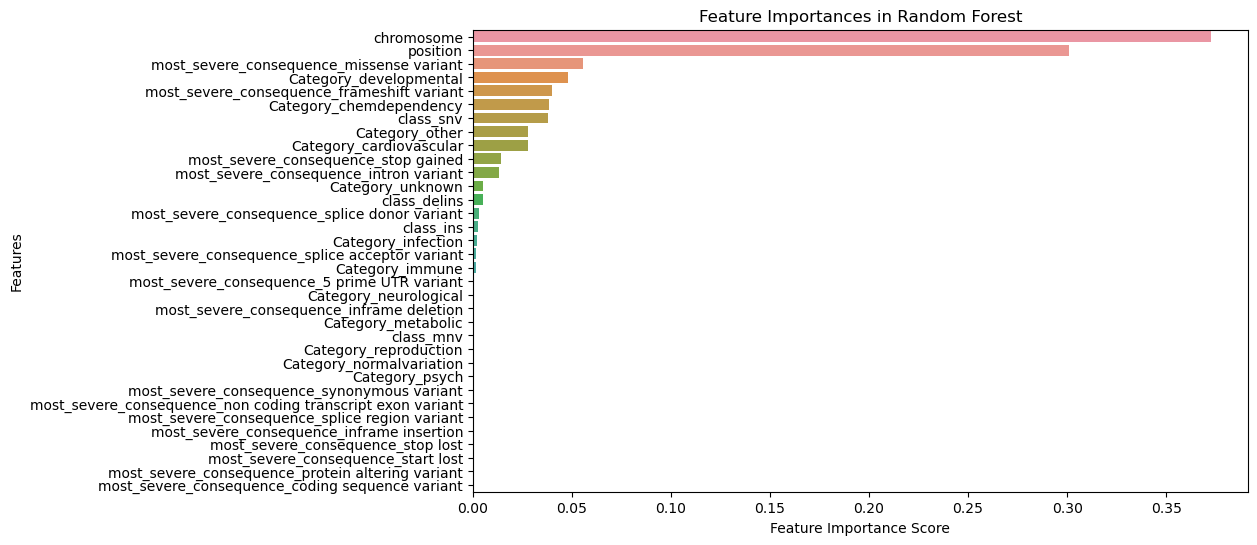

In [11]:
# Visualizing feature importance
feature_importances = pd.Series(rf_model.feature_importances_, index=X_train_final.columns)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Feature Importances in Random Forest')
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.show()

##### ROC Curve and AUC

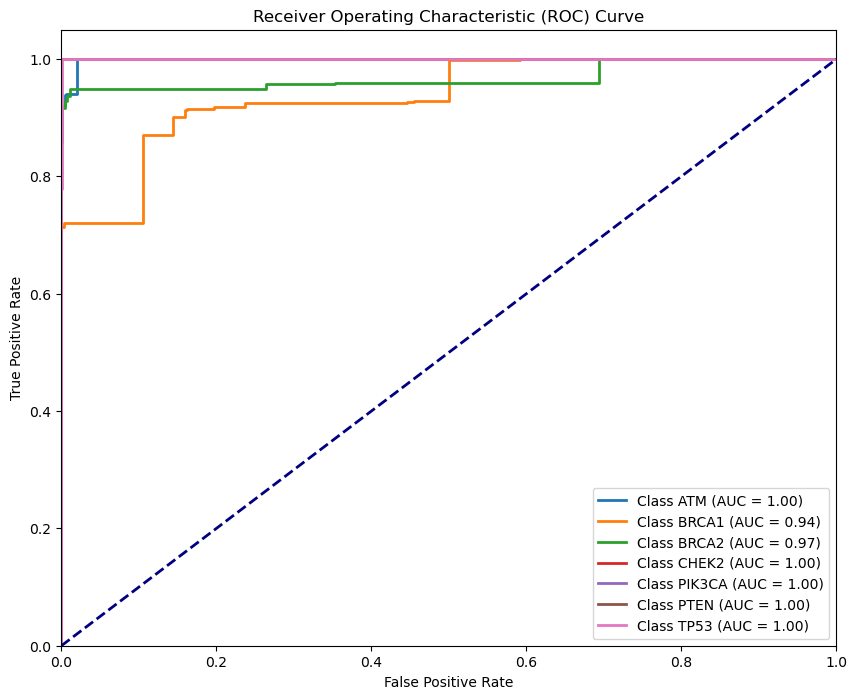

In [12]:
# Binarizing the test labels
y_test_bin = label_binarize(y_test, classes=range(len(label_encoder.classes_)))
y_probs = rf_model.predict_proba(X_test_final)

plt.figure(figsize=(10, 8))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, lw=2, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc_score(y_test_bin[:, i], y_probs[:, i]):.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()